In [183]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

In [184]:
# Data Preparation

In [185]:
df = pd.read_csv("../Data/train.csv")

In [186]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [187]:
df.shape

(8523, 12)

In [188]:
# Due to high number of missing values i am dropping these variables
df = df.drop(["Item_Weight","Outlet_Size"],axis=1)

In [189]:
for column in df.columns:
    print(column, ": "  ,df[column].unique())

Item_Identifier :  ['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']
Item_Fat_Content :  ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
Item_Visibility :  [0.0160473  0.01927822 0.01676007 ... 0.03518627 0.14522065 0.04487828]
Item_Type :  ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Item_MRP :  [249.8092  48.2692 141.618  ...  57.5904 214.5218  75.467 ]
Outlet_Identifier :  ['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
Outlet_Establishment_Year :  [1999 2009 1998 1987 1985 2002 2007 1997 2004]
Outlet_Location_Type :  ['Tier 1' 'Tier 3' 'Tier 2']
Outlet_Type :  ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']
Item_Outlet_Sales :  [3735.138   443.4228 2097.27   ... 7182.6504 3608.636  2778.3834]


In [190]:
df.Item_Fat_Content = df.Item_Fat_Content.replace({"low fat":"Low Fat","LF":"Low Fat","reg":"Regular"})

In [191]:
# We are taking recency of establishment from 2010 because maximum year is 2009
df["Num_Years"] = 2010 - df["Outlet_Establishment_Year"]

In [192]:
# Since visibility is pretty skewed
df["Item_Visibility"] = np.sqrt(df.Item_Visibility)

In [193]:
df = df.drop(["Outlet_Establishment_Year"],axis=1)

In [194]:
# We will target encode the Item_Type variable
item_encoding = df.groupby("Item_Type")["Item_Outlet_Sales"].mean().to_dict()
df.Item_Type = df.Item_Type.replace(item_encoding)

In [195]:
df.head()

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Num_Years
0,FDA15,Low Fat,0.126678,2232.542597,249.8092,OUT049,Tier 1,Supermarket Type1,3735.1380,11
1,DRC01,Regular,0.138846,2006.511735,48.2692,OUT018,Tier 3,Supermarket Type2,443.4228,1
2,FDN15,Low Fat,0.129461,2158.977911,141.6180,OUT049,Tier 1,Supermarket Type1,2097.2700,11
3,FDX07,Regular,0.000000,2289.009592,182.0950,OUT010,Tier 3,Grocery Store,732.3800,12
4,NCD19,Low Fat,0.000000,2258.784300,53.8614,OUT013,Tier 3,Supermarket Type1,994.7052,23


In [196]:
# It can be seen that the data is  almost balanced if we divide it according to the outlets
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
data_frames={}
for outlet in df.Outlet_Identifier.unique():
    data_frames[f"data_{outlet}"] = df[df["Outlet_Identifier"]==outlet]
    print(outlet, ": " ,df[df["Outlet_Identifier"]==outlet].shape)

OUT049 :  (930, 10)
OUT018 :  (928, 10)
OUT010 :  (555, 10)
OUT013 :  (932, 10)
OUT027 :  (935, 10)
OUT045 :  (929, 10)
OUT017 :  (926, 10)
OUT046 :  (930, 10)
OUT035 :  (930, 10)
OUT019 :  (528, 10)


In [197]:
data_frames.keys()

dict_keys(['data_OUT049', 'data_OUT018', 'data_OUT010', 'data_OUT013', 'data_OUT027', 'data_OUT045', 'data_OUT017', 'data_OUT046', 'data_OUT035', 'data_OUT019'])

In [198]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

models = {}
accuracy={}
for key in data_frames.keys():
    data = data_frames[key]
    data_X = pd.get_dummies(data[["Item_Fat_Content",	"Item_Visibility",	"Item_Type",	"Item_MRP"]])
    data_x = sc.fit_transform(data_X)
    data_Y = data["Item_Outlet_Sales"]

    #Train test split
    X_train,X_test,Y_train,Y_test = train_test_split(data_X,data_Y,test_size=0.2, random_state=123)

    # Model Building
    lr = LinearRegression()
    models[key] = lr
    lr.fit(X_train,Y_train)
    y_hat = lr.predict(X_test)
    mape = mean_absolute_percentage_error(Y_test,y_hat)
    print(f"MAPE {key}", mape)
    

MAPE data_OUT049 0.5218197065407527
MAPE data_OUT018 0.5587757909631602
MAPE data_OUT010 0.6353618330338122
MAPE data_OUT013 0.5123263770099258
MAPE data_OUT027 0.44097070950796824
MAPE data_OUT045 0.5397845162687348
MAPE data_OUT017 0.6344512590554201
MAPE data_OUT046 0.5322772994611238
MAPE data_OUT035 0.48119988716162715
MAPE data_OUT019 0.6372286146674974


## Now i Will cluster data and then will use it for making regression models

In [199]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [204]:
df_kmeans = pd.get_dummies(df,drop_first=True)
df_kmeans = sc.fit_transform(df_kmeans)

In [207]:
model = KMeans(n_clusters=3)
model.fit(df_kmeans)

KMeans(n_clusters=3)

In [230]:
inert=[]
for i in range(5,20):
    model = KMeans(n_clusters=i)
    model.fit(df_kmeans)
    inertia = model.inertia_
    inert.append(inertia)

In [233]:
elbow_data = pd.DataFrame([range(5,20),inert]).T
elbow_data = elbow_data.set_index(0)


<AxesSubplot:xlabel='0'>

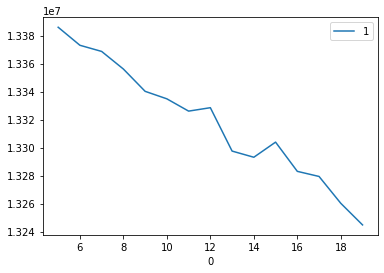

In [234]:
elbow_data.plot()

In [210]:
model.inertia_

13398703.05714829

In [ ]:
KMeans?

Init signature:
KMeans(
    n_clusters=8,
    *,
    init='k-means++',
    n_init=10,
    max_iter=300,
    tol=0.0001,
    precompute_distances='deprecated',
    verbose=0,
    random_state=None,
    copy_x=True,
    n_jobs='deprecated',
    algorithm='auto',
)
Docstring:     
K-Means clustering.

Read more in the :ref:`User Guide <k_means>`.

Parameters
----------

n_clusters : int, default=8
    The number of clusters to form as well as the number of
    centroids to generate.

init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
    Method for initialization:

    'k-means++' : selects initial cluster centers for k-mean
    clustering in a smart way to speed up convergence. See section
    Notes in k_init for more details.

    'random': choose `n_clusters` observations (rows) at random from data
    for the initial centroids.

    If an array is passed, it should be of shape (n_clusters, n_features)
    and gives

In [ ]:
df

,Item_Visibility,Item_Type,Item_MRP,Item_Outlet_Sales,Num_Years,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,...,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,0.126678,2232.542597,249.8092,3735.1380,11,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,0.138846,2006.511735,48.2692,443.4228,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,0.129461,2158.977911,141.6180,2097.2700,11,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,0.000000,2289.009592,182.0950,732.3800,12,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0.000000,2258.784300,53.8614,994.7052,23,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,0.238293,2277.321739,214.5218,2778.3834,23,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
8519,0.216754,1952.971207,108.1570,549.2850,8,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
8520,0.187580,2010.000265,85.1224,1193.1136,6,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
8521,0.381078,2277.321739,103.1332,1845.5976,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
